# Text Analytics - Assignment 3

Grammatikopoulou Maria - f3352310

Phevos A. Margonis - f3352317

Moniaki Melina - f3352321

#### Exercise 1

In [393]:
#!pip install fasttext-wheel
#!pip install --upgrade tensorflow

In [394]:
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
#!gzip -d cc.en.300.bin.gz

In [395]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import time
import re

# ML libraries
from sklearn.metrics import (auc, classification_report,
                             f1_score, precision_recall_curve,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Bidirectional, GRU, Lambda, BatchNormalization, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Add


In [396]:
# NLTK
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# Progress bar
from tqdm import tqdm

# NLP libraries
# Install spacy
#!pip install spacy
# Download the English language model
#!python -m spacy download en
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [397]:
TARGET_NAMES = ['negative', 'positive']

In [398]:
csv_file_path = "C:\\Users\\maria\\OneDrive\\Υπολογιστής\\Υλικο Μεταπτυχιακο\\Text Analytics\\MLP Exercise Text Analytics\\IMDB Dataset.csv"
# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the DataFrame
print(df.head())
df.shape
#df['review'][3]
#sns.countplot(x="sentiment", data=df)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


(50000, 2)

In [399]:
oldDF = df
df = df.iloc[:50000,:]

In [400]:

TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)


def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()
    # Remove html tags
    sentence = remove_tags(sentence)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.
    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence


# Calling preprocessing_text function on df
X = []
sentences = list(df['review'])
for sen in tqdm(sentences, desc='Preprocessing: '):
    X.append(preprocess_text(sen))
    
print(X[0])

Preprocessing: 100%|██████████| 50000/50000 [00:28<00:00, 1769.64it/s]

one reviewers mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skills

In [401]:
# Converting sentiment labels to 0 & 1
y = df['sentiment']
y = np.array(list(map(lambda x: 1 if x == "positive" else 0, y)))

In [402]:
# Split the data into training (70%) and temporary data (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# Split the temporary data into testing (50%) and validation (50%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print('Train samples: {}'.format(len(X_train)))
print('Val samples: {}'.format(len(X_val)))
print('Test samples: {}'.format(len(X_test)))

Train samples: 35000
Val samples: 7500
Test samples: 7500


In [403]:
nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])
nlp.add_pipe('sentencizer')

def tokenize_samples(samples):

    tokenized_samples = []
    for i in tqdm(range(len(samples)), desc='Tokenize: '):
        doc = nlp(samples[i])  # Tokenize the sample into sentences
        tokens = []
        for sent in doc.sents:
            for tok in sent:  # Iterate through the words of the sentence
                if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or tok.text.lower() in STOP_WORDS:
                    continue
                if tok.text.strip():
                    tokens.append(tok.text.replace('"', "'").strip())
        tokenized_samples.append(tokens)

    return tokenized_samples


X_train_tokenized = tokenize_samples(X_train)
X_val_tokenized = tokenize_samples(X_val)
X_test_tokenized = tokenize_samples(X_test)

Tokenize:   0%|          | 0/35000 [00:00<?, ?it/s]C:\Users\maria\anaconda3\anaconda_3\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
Tokenize: 100%|██████████| 7500/7500 [01:21<00:00, 92.44it/s] 


In [404]:
print(np.mean([len(x) for x in X_train_tokenized]))
print(np.std([len(x) for x in X_train_tokenized]))

102.10954285714286
78.60863093519252


In [405]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),
                             max_features=5000,
                             sublinear_tf=True)

X_train_tfidf = vectorizer.fit_transform([" ".join(x) for x in X_train_tokenized])
X_val_tfidf = vectorizer.transform([" ".join(x) for x in X_val_tokenized])
X_test_tfidf = vectorizer.transform([" ".join(x) for x in X_test_tokenized])

In [406]:
# Reduce dimensionality using svd 5000 --> 500
svd = TruncatedSVD(n_components=500, random_state=4321)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd = svd.transform(X_val_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

In [407]:

def my_auc_report(y_true, y_pred, title='UNK') -> None:
    """
    Inputs the y_true and y_pred,
    Prints the PR-AUC for each class
    """
    print(f"=== PR-AUC for {title} ===")
    precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 0], pos_label=0)
    area = auc(recall, precision)
    print(f"PR-AUC for class 0: {area*100:.2f}%")
    precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 1])
    area = auc(recall, precision)
    print(f"PR-AUC for class 1: {area*100:.2f}%\n")

##Dummy classifier
# Train
# The dummy classifier always predicts the 'most frequent' class
baseline = DummyClassifier(strategy='most_frequent')
start_time = time.time()
baseline.fit(X_train_svd, y_train)
majority_val_accuracy = baseline.score(X_val_svd, y_val)
print("Training took: {} seconds \n".format(time.time() - start_time))

# Evaluate
model = baseline
# Classification Reports
predictions = model.predict(X_train_svd)
print(classification_report(y_train, predictions, zero_division=0, target_names=TARGET_NAMES))
predictions = model.predict(X_val_svd)
print(classification_report(y_val, predictions, zero_division=0, target_names=TARGET_NAMES))
predictions = model.predict(X_test_svd)
print(classification_report(y_test, predictions, zero_division=0, target_names=TARGET_NAMES))

# Prepare the predictions for PR-AUC
predictions_train = model.predict_proba(X_train_svd)
predictions_val = model.predict_proba(X_val_svd)
predictions_test = model.predict_proba(X_test_svd)
# PR-AUC report
my_auc_report(y_train, y_pred=predictions_train, title='Train')
my_auc_report(y_val, y_pred=predictions_val, title='Validation')
my_auc_report(y_test, y_pred=predictions_test, title='Test')

Training took: 0.015321016311645508 seconds 

              precision    recall  f1-score   support

    negative       0.50      1.00      0.67     17589
    positive       0.00      0.00      0.00     17411

    accuracy                           0.50     35000
   macro avg       0.25      0.50      0.33     35000
weighted avg       0.25      0.50      0.34     35000

              precision    recall  f1-score   support

    negative       0.50      1.00      0.66      3722
    positive       0.00      0.00      0.00      3778

    accuracy                           0.50      7500
   macro avg       0.25      0.50      0.33      7500
weighted avg       0.25      0.50      0.33      7500

              precision    recall  f1-score   support

    negative       0.49      1.00      0.66      3689
    positive       0.00      0.00      0.00      3811

    accuracy                           0.49      7500
   macro avg       0.25      0.50      0.33      7500
weighted avg       0.24     

In [408]:
### Logistic Regression
clf = LogisticRegression()
clf.fit(X_train_svd, y_train)
logit_val_accuracy = clf.score(X_val_svd, y_val)

# Evaluate
model = clf
# Classification Reports
predictions = model.predict(X_train_svd)
print(classification_report(y_train, predictions, target_names=TARGET_NAMES))
predictions = model.predict(X_val_svd)
print(classification_report(y_val, predictions, target_names=TARGET_NAMES))
predictions = model.predict(X_test_svd)
print(classification_report(y_test, predictions, target_names=TARGET_NAMES))

# Prepare the predictions for PR-AUC
predictions_train = model.predict_proba(X_train_svd)
predictions_val = model.predict_proba(X_val_svd)
predictions_test = model.predict_proba(X_test_svd)
# PR-AUC report
my_auc_report(y_train, y_pred=predictions_train, title='Train')
my_auc_report(y_val, y_pred=predictions_val, title='Validation')
my_auc_report(y_test, y_pred=predictions_test, title='Test')

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88     17589
    positive       0.87      0.90      0.88     17411

    accuracy                           0.88     35000
   macro avg       0.88      0.88      0.88     35000
weighted avg       0.88      0.88      0.88     35000

              precision    recall  f1-score   support

    negative       0.89      0.86      0.87      3722
    positive       0.87      0.89      0.88      3778

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      3689
    positive       0.87      0.89      0.88      3811

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500

=== PR-AUC for Trai

In [409]:
MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 128 # To max megethos keimenou pou borei na dextei to diktio
EMBEDDING_DIM = 300

# output_mode -> exei kai alla opws "TF-IDF"
# Orizoume an theloume kai ngrams
# output_sequence_length to i sto h_{i}?

vectorizer = tf.keras.layers.TextVectorization(max_tokens=MAX_WORDS, output_mode='int',
                                               ngrams=1, output_sequence_length=MAX_SEQUENCE_LENGTH)

vectorizer.adapt(X_train)

In [410]:
input_array = [["sentence with some words"], ["another sentence with unfjfh words"]]
vectorizer.call(input_array)

<tf.Tensor: shape=(2, 128), dtype=int64, numpy=
array([[3700,    1,    1,  527,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [  65, 3700,    1,    1,  527,    0,    0,    0,    0,    0,    0,
           0,

In [411]:
import fasttext
import numpy as np

fasttext_model = fasttext.load_model('C:\\Users\\maria\\cc.en.300.bin\\cc.en.300.bin')
embedding_matrix = np.zeros(shape=(MAX_WORDS, 300))

for w2idx, _word in enumerate(vectorizer.get_vocabulary()):
    # Skip PAD and UNK tokens
    if w2idx >= 2:
        embedding_matrix[w2idx] = fasttext_model.get_word_vector(_word)

del fasttext_model

In [412]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
          val_targ = np.argmax(val_targ, -1)


        _val_f1 = f1_score(val_targ, val_predict,average="weighted", zero_division=1)
        _val_recall = recall_score(val_targ, val_predict,average="weighted", zero_division=1)
        _val_precision = precision_score(val_targ, val_predict,average="weighted", zero_division=1)

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

In [413]:
def self_attention(x):
    rnn_states, scores = x # unpack x [( ta h tou Unrolled RNN), (ta scores apo to MLP)]
    a = tf.nn.softmax(tf.squeeze(scores, axis=-1), axis=-1) # Efarmozw to activation function sto score pou mas edwse to MLP gia kathe lexi (gia na ginoun pithanotites) -> Twra exw ta 'α'!
    z = tf.multiply(tf.expand_dims(a, axis=-1), rnn_states) # [α*h] # To embedding ths protasis
    z = tf.math.reduce_sum(z, axis=1) # Σz
    return z

In [414]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

GRU_SIZE = 300 # h diastasi tou h
DENSE = 1000

# TENSORBOARD: Create a log directory with a timestamp to create a unique directory for each run
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=0)

# Functional API
text = Input(shape=(1,), dtype = tf.string, name = "input_text")
vectorized = vectorizer(text)
word_embeddings = Embedding(MAX_WORDS, EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              mask_zero=True,
              trainable=False)(vectorized)   #create the word embeddings
word_embeddings = Dropout(0.33)(word_embeddings)

#RNN
rnn_states_1 = Bidirectional(GRU(GRU_SIZE,
                             return_sequences=True,
                             recurrent_dropout=0.33))(word_embeddings)
rnn_states_1 = LayerNormalization()(rnn_states_1)
rnn_states_2 = Bidirectional(GRU(GRU_SIZE,return_sequences=True,recurrent_dropout=0.33))(rnn_states_1)  #stacked rnns (2)
rnn_states_2 = LayerNormalization()(rnn_states_2)
rnn_residuals = Add()([rnn_states_1,rnn_states_2])

# self-attention
mlp_scores = Dense(16, activation='relu')(rnn_residuals)
#mlp_scores = BatchNormalization()(mlp_scores)
mlp_scores = Dropout(0.33)(mlp_scores)
mlp_scores = Dense(16, activation='relu')(mlp_scores)
#mlp_scores = BatchNormalization()(mlp_scores)
mlp_scores = Dropout(0.33)(mlp_scores)
#mlp_scores = Dense(16, activation='relu')(mlp_scores)
#mlp_scores = Dropout(0.33)(mlp_scores)
mlp_scores = Dense(1)(mlp_scores) # To SELF-ATTENSION layer # Dense(1): 'Linear layer' -> Enan output nevrona gia na mou dwsei to 'o' (PROSOXI DEN EXEI ACTIVATION AKOMA)!
centroids = Lambda(self_attention)([rnn_residuals, mlp_scores]) # To Lambda layer ipostirizei mono tou masking!

# MLP
rich_features = Dense(units=384, activation='relu')(centroids)
rich_features = Dropout(0.33)(rich_features)
#rich_features = Dense(units=16, activation='relu')(rich_features)
#rich_features = Dropout(0.33)(rich_features)
# rich_features = Dense(units=64, activation='relu')(rich_features)
# rich_features = Dropout(0.33)(rich_features)

sentiment = Dense(1, activation= 'sigmoid', name="output_sentiment")(rich_features)

model = tf.keras.Model(inputs=text, outputs=sentiment)


print(model.summary())

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])

# train_data = np.array([[" ".join(x_train)] for x_train in X_train_tokenized])
# val_data = np.array([[" ".join(x_val)] for x_val in X_val_tokenized])

if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')
# Callback to save the Keras model or model weights at some frequency.
checkpoint = ModelCheckpoint(
    'checkpoints/model_ex1',
    monitor='val_loss',  # Save the model that scores the best @ validation accuracy
    mode='min',  # Since accuracy -> maximization
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    save_format='tf'  # Use TensorFlow format for saving (due to TextVectorization layer not supporting HDF5)
)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

start_training_time = time.time()

history = model.fit(
    np.array(X_train),
    y_train,
    validation_data=(np.array(X_val), y_val),
    batch_size=128,
    epochs=50,
    shuffle=True,
    callbacks=[checkpoint, early_stopping, tensorboard_callback])

end_training_time = time.time()

print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} \n')

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_text (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_16 (Tex  (None, 128)                  0         ['input_text[0][0]']          
 tVectorization)                                                                                  
                                                                                                  
 embedding_21 (Embedding)    (None, 128, 300)             3000000   ['text_vectorization_16[0][0]'
                                                          0         ]                             
                                                                                           

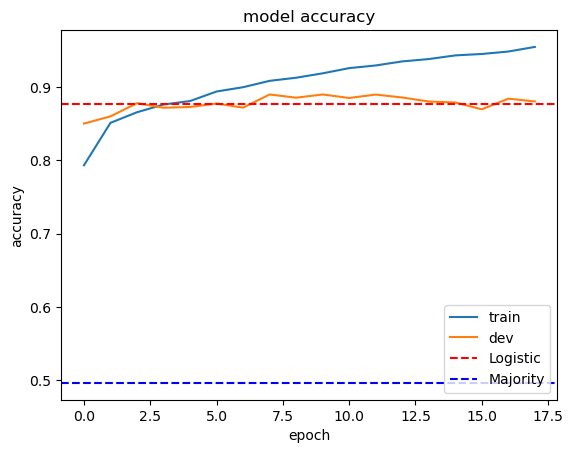

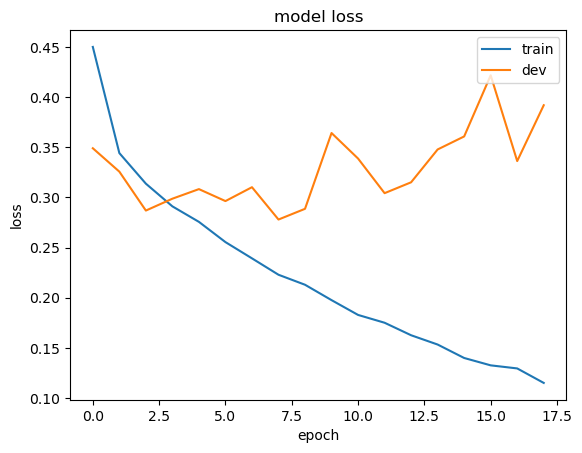

In [415]:
# history: Returned by the fit. Keeps the metrics for each epoch
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.axhline(y=logit_val_accuracy, color='red', linestyle='--', label='Logistic')
plt.axhline(y=majority_val_accuracy, color='blue', linestyle='--', label='Majority')
plt.legend(['train', 'dev', 'Logistic', 'Majority'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

# # %% Load the best model saved from ModelCheckpoint
# from tensorflow.keras.models import load_model

# model = load_model('checkpoints/model_ex1')

In [416]:
predictions = (model.predict(X_train) > 0.5)
print(classification_report(y_train, predictions, target_names=TARGET_NAMES))
predictions = (model.predict(X_val) > 0.5)
print(classification_report(y_val, predictions, target_names=TARGET_NAMES))
predictions = (model.predict(X_test) > 0.5)
print(classification_report(y_test, predictions, target_names=TARGET_NAMES))

1094/1094 [==============================] - 2293s 2s/step
              precision    recall  f1-score   support

    negative       0.95      0.94      0.95     17589
    positive       0.94      0.95      0.95     17411

    accuracy                           0.95     35000
   macro avg       0.95      0.95      0.95     35000
weighted avg       0.95      0.95      0.95     35000

235/235 [==============================] - 466s 2s/step
              precision    recall  f1-score   support

    negative       0.89      0.89      0.89      3722
    positive       0.89      0.89      0.89      3778

    accuracy                           0.89      7500
   macro avg       0.89      0.89      0.89      7500
weighted avg       0.89      0.89      0.89      7500

235/235 [==============================] - 465s 2s/step
              precision    recall  f1-score   support

    negative       0.89      0.89      0.89      3689
    positive       0.89      0.89      0.89      3811

    accurac

In [417]:
def custom_pred_proba(X) -> np.ndarray[tuple[float, float]]:
    ''' Calculates the classic .predict_proba() for the X input feature matix,
        because it is needed for the precision_recall_curve.
        Returns an array: [P(x=0), P(x=1)] '''
    pred = model.predict(X)
    return np.hstack((1-pred, pred))


# Prepare predictions for PR-AUC
predictions_train = custom_pred_proba(X_train)
predictions_val = custom_pred_proba(X_val)
predictions_test = custom_pred_proba(X_test)
# PR-AUC report
my_auc_report(y_train, y_pred=predictions_train, title='Train')
my_auc_report(y_val, y_pred=predictions_val, title='Validation')
my_auc_report(y_test, y_pred=predictions_test, title='Test')

235/235 [==============================] - 482s 2s/step
=== PR-AUC for Train ===
PR-AUC for class 0: 98.86%
PR-AUC for class 1: 98.80%

=== PR-AUC for Validation ===
PR-AUC for class 0: 95.70%
PR-AUC for class 1: 95.49%

=== PR-AUC for Test ===
PR-AUC for class 0: 96.09%
PR-AUC for class 1: 95.74%

